In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [2]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
#df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test_Keep.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)
(800,)


# Model Implementation

In [4]:
def gini(sequence):
    classes, counts = np.unique(sequence, return_counts=True)
    impurity = 1.0
    for count in counts:
        prob = count / len(sequence)
        impurity -= prob ** 2
    return impurity
    #probs = counts / len(sequence)
    #impurity = np.sum(probs ** 2)
    #return 1 - impurity


def entropy(sequence):
    classes, counts = np.unique(sequence, return_counts=True)
    impurity = 0.0
    for count in counts:
        prob = count / len(sequence)
        impurity += prob * np.log2(prob)
    return -impurity
    
    #probs = counts / len(sequence)
    #impurity = np.sum(probs * np.log2(probs))
    #return 0 - impurity

In [5]:
class Tree():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self):       
        self.left = None
        self.right = None
        self.output = None
        
        self.samples = None
        self.feature = None
        self.threshold = None
        self.gain = None


In [6]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        
        """
            You can add/change any variables/methods to meet your need.
        """

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth

        if max_features is None:
            self.max_features = None
        else:
            self.max_features = int(max_features)
        
        self.importance = {}
        self.root = None
        self.n_features = None

    def fit(self, X, y):
        def build_tree(X, y, depth):
            tree = Tree()
            tree.samples = len(y)
            if len(np.unique(y)) == 1:
                tree.output = y[0]
                return tree
            
            if depth >= self.max_depth:
                tree.output = np.bincount(y).argmax()
                return tree
            
            best_feature, best_threshold, best_gain = self.find_best_split(X, y)

            
            if best_feature is None or best_threshold is None:
                tree.output = np.bincount(y).argmax()
                return tree

            tree.feature = best_feature
            tree.threshold = best_threshold
            tree.gain = best_gain

            left_mask = []
            right_mask = []
            for i in range(len(X)):
                if X[i, best_feature] <= best_threshold:
                    left_mask.append(True)
                    right_mask.append(False)
                else:
                    left_mask.append(False)
                    right_mask.append(True)

            tree.left = build_tree(X[left_mask], y[left_mask], depth + 1)
            tree.right = build_tree(X[right_mask], y[right_mask], depth + 1)
            
            return tree
        
        self.n_features = X.shape[1]
        y = y.astype(int)
        self.root = build_tree(X, y, 0)

    def find_best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        if self.max_features is None:
            feature_indices = range(self.n_features)
        else:
            feature_indices = np.random.choice(self.n_features, self.max_features, replace=False)

        for feature in feature_indices:
            column = X[:, feature]
            thresholds = np.unique(column)
            for threshold in thresholds:
                y_left = y[column <= threshold]
                y_right = y[column > threshold]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = self.criterion(y) - len(y_left) / len(y) * self.criterion(y_left) - len(y_right) / len(y) * self.criterion(y_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain
    
    
    def predict(self, X):
        predictions = np.empty(X.shape[0], dtype=int)
        
        for i, x in enumerate(X):
            tree = self.root
            while tree.threshold is not None:
                if x[tree.feature] <= tree.threshold:
                    tree = tree.left
                else:
                    tree = tree.right
            
            predictions[i] = tree.output
            
        return predictions

    def countImportance(self):
        if self.root is None:
            raise Exception("Decision tree has not been fit yet.")

        def traverse_tree(tree, importance):
            if tree is None:
                return

            if tree.feature is not None:
                importance[tree.feature] += tree.samples / self.root.samples * tree.gain

            traverse_tree(tree.left, importance)
            traverse_tree(tree.right, importance)

        self.importance = {i: 0 for i in range(self.n_features)}
        traverse_tree(self.root, self.importance)

In [7]:
class RandomForest():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        for i in range(self.n_estimators):
            tree = DecisionTree(criterion = self.criterion, max_features = self.max_features, max_depth = self.max_depth)
            
            if self.boostrap:
                samples_idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
                X_subset = X[samples_idx]
                y_subset = y[samples_idx]
            else:
                y_subset = y
            
            tree.fit(X_subset, y_subset)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
            
        # majority vote
        def majority_vote(x):
            counts = np.bincount(x.astype(int))
            return np.argmax(counts)
        
        return np.apply_along_axis(majority_vote, axis=1, arr=predictions)

# Questions for Decision Tree

In [8]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [9]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train)

acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.73125


In [10]:
""" Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))

assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

In [11]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.86375


In [12]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))


Q3-1 criterion='gini':  0.73125


In [13]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.76875


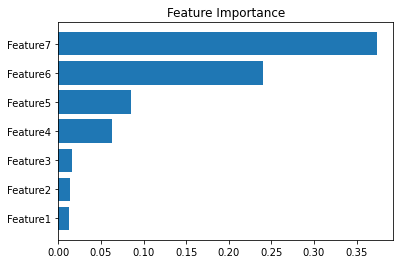

In [14]:
# For Q4

# Use simply counting to get the feature importance: dt_depth10.importance

dt_depth10.countImportance()
#print("dt_depth10.importance", dt_depth10.importance)

importance_sorted = sorted(zip(dt_depth10.importance.values(), dt_depth10.importance.keys()))
importance_values = [val[0] for val in importance_sorted]


labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']

plt.title('Feature Importance')

plt.barh(range(len(importance_values)), importance_values)
plt.yticks(range(len(labelList)), labelList)

plt.show()

# Questions for Random Rorest

In [15]:
# For Q5-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q5-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q5-1 n_estimators=10:  0.89


In [16]:
# For Q5-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(0)

rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q5-2 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q5-2 n_estimators=50:  0.89875


In [17]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q6-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q6-1 max_features='sqrt':  0.89


In [18]:
# For Q6-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(0)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q6-2 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q6-2 max_features='All':  0.875


# Train your own model

In [19]:
# Build and train your model

np.random.seed(220)

your_model_RF = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='entropy', max_depth=None)
your_model_RF.fit(X_train, y_train)

print("your_model_RF: ", accuracy_score(y_val, your_model_RF.predict(X_val)))

your_model_RF:  0.91


In [20]:
test_pred = your_model_RF.predict(X_test)

print("test_pred shape: ", test_pred.shape)

test_pred shape:  (800,)


In [21]:
# output csv
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("sample_output.csv")